#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

## note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

#Task 1: 
###Event detection: Identify the most prominent event.
###There is a very significant drop (>3-sigma) in all time series.
###Identify it and figure out what it is due to.

In [2]:
# Loading required packages
%pylab inline
import numpy as np
import pylab as pl
import pandas as pd
import json
import urllib2

# Using the matplotlib customizing file
jsonFile = urllib2.urlopen('https://raw.githubusercontent.com/fedhere/PUI2015_fbianco/master/fbb_matplotlibrc.json')
s = json.load(jsonFile)
plt.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Loading the MTA Fare cube data
mtacube = np.load("MTA_Fare.npy")

print type(mtacube) # object type
print mtacube.dtype # data type
print mtacube.shape # attributes
print mtacube.ndim # dimensions

<type 'numpy.ndarray'>
int32
(600L, 23L, 194L)
3


In [4]:
# Replacing -1 values with nan
mtacube = mtacube.astype('float') # Converting the datatype from int to float
mtacube[mtacube == -1] = np.nan
print mtacube.shape

(600L, 23L, 194L)


In [5]:
# Creating weeks object for the given time period
weeks = np.arange('2010-05-28', '2014-02-14', dtype='datetime64[W]')
print type(weeks)
print weeks.shape

# Summing up MTA Fare array across station and card type axes to get ridership for weeks
ridesperWk = np.nansum(mtacube, axis=(0, 1))
print type(ridesperWk)
print ridesperWk.shape

<type 'numpy.ndarray'>
(194L,)
<type 'numpy.ndarray'>
(194L,)


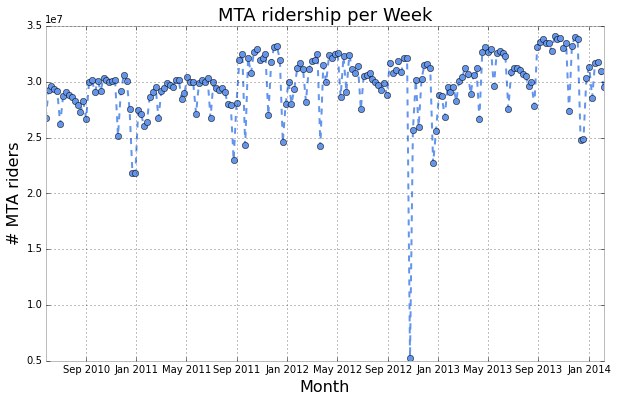

In [6]:
# Plotting MTA ridership by Week for the given period
pl.figure(figsize=(10,6))
pl.plot_date(weeks, ridesperWk, xdate=True,
             c='cornflowerblue', ls= '--', lw=2)

pl.xlabel('Month', fontsize=16)
pl.ylabel('# MTA riders', fontsize=16)
pl.title('MTA ridership per Week', fontsize=18)

In [10]:
# Computing thresholds
tot_avg, tot_std = np.mean(ridesperWk), np.std(ridesperWk)
thresholds = [tot_avg + 3*tot_std, 
              tot_avg - 3*tot_std]
print thresholds
print thresholds[0]
print thresholds[1]

[38733231.136236683, 20829468.606031362]
38733231.1362
20829468.606


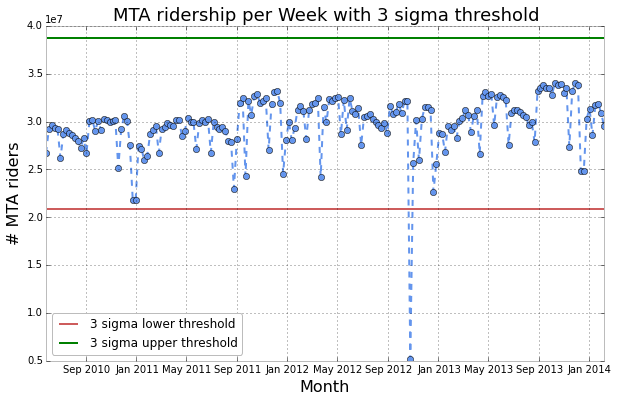

In [9]:
# Plotting MTA ridership by Week for the given period with thresholds
pl.figure(figsize=(10,6))
pl.plot_date(weeks, ridesperWk, xdate=True,
             c='cornflowerblue', ls= '--', lw=2)
pl.plot([weeks[0], weeks[193]], [thresholds[1], thresholds[1]], label = '3 sigma lower threshold')
pl.plot([weeks[0], weeks[193]], [thresholds[0], thresholds[0]], label = '3 sigma upper threshold')

pl.xlabel('Month', fontsize=16)
pl.ylabel('# MTA riders', fontsize=16)
pl.title('MTA ridership per Week with 3 sigma threshold', fontsize=18)
pl.legend(loc="best")

> "**The most prominent event we can notice from the above plot is happening between the months of Sep 2012 and Jan 2013. During this period, major event that has caused such a significant change is Hurricane Sandy.**

#Task 2: 
###Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [11]:
ridetypes = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 
                      'afas', 'exp','ez', 'ff','mc','mr','month','rfm',
                      'rr','sen','spec','tcmc','t', 'umlim','xbus','stud'])

print type(ridetypes)
print ridetypes.shape

<type 'numpy.ndarray'>
(23L,)


In [12]:
# Summing the MTA cube array by station axis
mtatypes = np.nansum(mtacube, axis=(0))
print type(mtatypes)
print mtatypes.shape

<type 'numpy.ndarray'>
(23L, 194L)


In [13]:
# Summing the MTA cube array by station axis
mtatypes = np.nansum(mtacube, axis=(0))
print type(mtatypes)
print mtatypes.shape

<type 'numpy.ndarray'>
(23L, 194L)


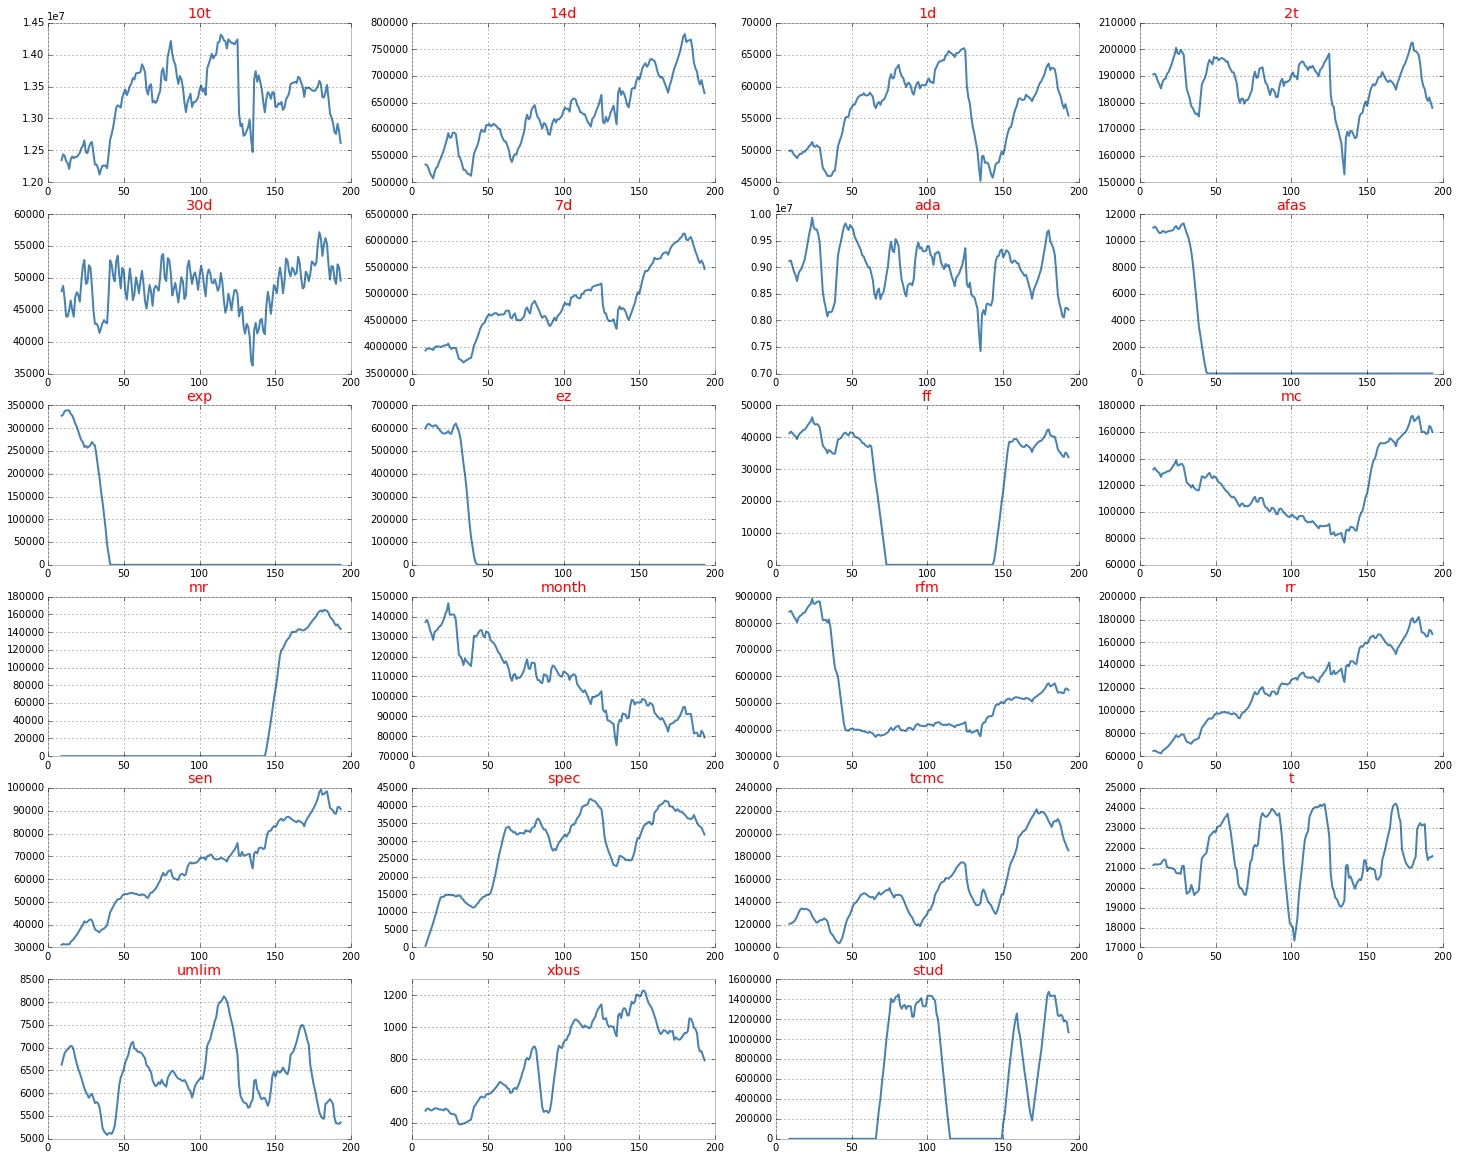

In [14]:
# Plotting rolling mean outputs for all mta card types
fig = pl.figure(figsize=(25,20))
for i in range(len(ridetypes)):
    data = pd.Series(mtatypes[i], weeks)
    rlmean = pd.rolling_mean(data, 10)
    pl.subplot(6,4,i+1)
    pl.plot(rlmean)
    pl.title(ridetypes[i], color='r')

> "**From the above plots, we can observe that mta card types like 14d, 7d, rr, sen, tcmc seems to show a steadily increasing trend. Whereas mta card type month is showing a steadily decreasing trend.**

#Task 3:
###Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [15]:
# Summing the MTA cube array by ride type axis
stationdata = np.nansum(mtacube, axis=1)
print type(stationdata)
print stationdata.shape

<type 'numpy.ndarray'>
(600L, 194L)


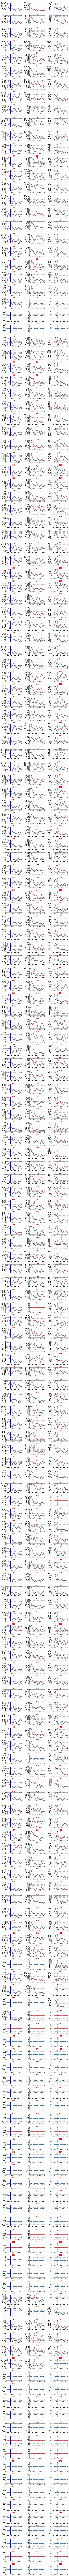

In [16]:
fig = pl.figure(figsize=(10,400))

for i in range(len(stationdata)):
    f = np.abs(np.fft.rfft(stationdata[i]))
    pl.subplot(200,3,i+1)
    pl.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms=8)
    pl.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
    pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, bottom=.1)
    pl.xlim(0,1.0/15)
    pl.axvline(1.0/52)
    pl.title(i+1, color='r')

In [17]:
# Looking for stations with prominent annual periodicity
stations = range(1, 601)

periods = []
for i in range(600):
    periods.append(np.abs(np.fft.rfft(stationdata[i]))[4])
    
annualTrend = pd.DataFrame({'stations':stations, 
                            'frequency':periods})

annualTrend.sort('frequency', ascending=False).head(4)

frequency  stations
0    2980160.635595         1
194  2950388.929214       195
150  2931895.876951       151
327  2402218.580959       328

> "**Stations indexed 1, 151, 195 and 328 are the top four groups that show prominent periodic trend on an annual period (52 weeks).**

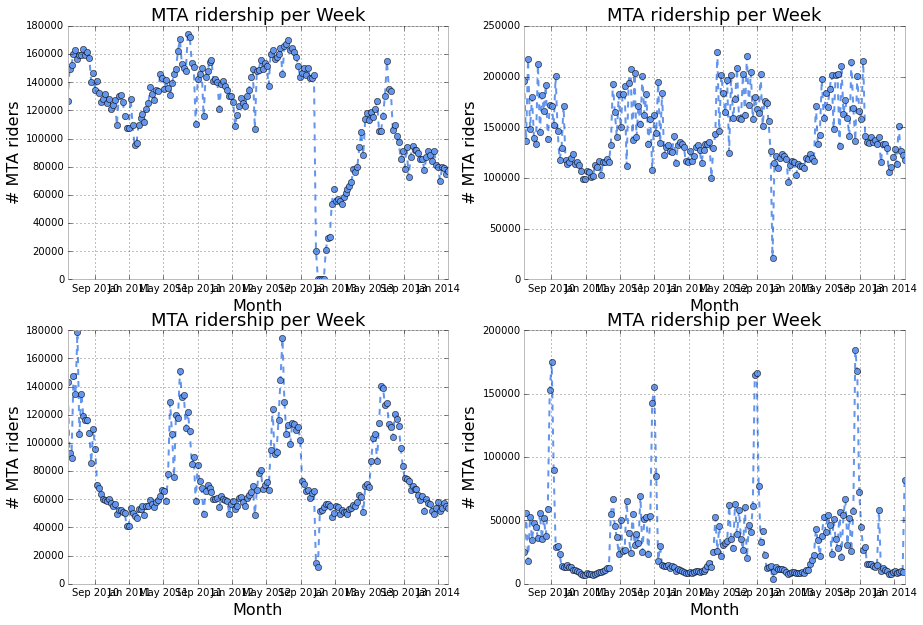

In [21]:
# Looking closely at the 4 stations obtained above
pl.figure(figsize=(15,10))
pl.subplot(2,2,1)
pl.plot_date(weeks, stationdata[0], xdate=True,
             c='cornflowerblue', ls= '--', lw=2)
pl.xlabel('Month', fontsize=16)
pl.ylabel('# MTA riders', fontsize=16)
pl.title('MTA ridership per Week', fontsize=18)

pl.subplot(2,2,2)
pl.plot_date(weeks, stationdata[194], xdate=True,
            c='cornflowerblue', ls= '--', lw=2)
pl.xlabel('Month', fontsize=16)
pl.ylabel('# MTA riders', fontsize=16)
pl.title('MTA ridership per Week', fontsize=18)

pl.subplot(2,2,3)
pl.plot_date(weeks, stationdata[150], xdate=True,
             c='cornflowerblue', ls= '--', lw=2)
pl.xlabel('Month', fontsize=16)
pl.ylabel('# MTA riders', fontsize=16)
pl.title('MTA ridership per Week', fontsize=18)

pl.subplot(2,2,4)
pl.plot_date(weeks, stationdata[327], xdate=True,
             c='cornflowerblue', ls= '--', lw=2)
pl.xlabel('Month', fontsize=16)
pl.ylabel('# MTA riders', fontsize=16)
pl.title('MTA ridership per Week', fontsize=18)

> "**Stations indexed 1, 151, 195 and 328 are the top four groups that show prominent periodic trend on an annual period (52 weeks). In general all the graphs showcase annual periodicity trend in the months before September month and following upto that. One probable reason that would be driving this would be probable back to school sales.**

#EXTRA CREDIT: Cluster. 
##Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
##Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

##i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

##removing empty light curves
tots = tots[tots.std(1)>0]

##with Kmeans you have to choose the number of clusters ahead km = 

KMeans(n_clusters=10)

##and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

##then you can run:

km.fit(vals)

In [22]:
# Loading the MTA Fare cube data
dataset = np.load("MTA_Fare.npy")

print type(dataset) # object type
print dataset.dtype # data type
print dataset.shape # attributes
print dataset.ndim # dimensions

# Converting the 3D array to 2D array
tots = dataset.transpose(2,0,1).reshape(dataset.shape[2], dataset.shape[1]*dataset.shape[0]).T
print type(tots)
print tots.shape

# Removing for observations with -1 values
tots = tots[tots.std(1)>0]
print type(tots)
print tots.shape

# Scaling the time series values
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

# Fitting KMeans on the ts data
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10)
km.fit(vals)

<type 'numpy.ndarray'>
int32
(600L, 23L, 194L)
3
<type 'numpy.ndarray'>
(13800L, 194L)
<type 'numpy.ndarray'>
(9317L, 194L)


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [24]:
# Extracting cluster labels
clusters = km.labels_
print clusters.shape
print type(clusters)
print np.unique(clusters)
clusters

(9317L,)
<type 'numpy.ndarray'>
[0 1 2 3 4 5 6 7 8 9]


array([9, 9, 9, ..., 8, 4, 8])

In [25]:
# Extracting cluster centroids for plotting on single plot
centroids = km.cluster_centers_
centroids.shape
centroids

array([[-0.74806589, -0.74795014, -0.74304193, ...,  0.8692046 ,
         1.22750191,  0.13386381],
       [-0.0878783 , -0.07767031, -0.02632861, ...,  0.20851714,
         0.19858231,  0.05223083],
       [ 1.98542392,  2.18669231,  2.30899381, ..., -0.32445443,
        -0.33899297, -0.36970868],
       ..., 
       [ 0.49103444,  0.90578952,  0.86151664, ...,  1.052631  ,
         0.91749297,  0.66033528],
       [-1.24468234, -0.97078881, -0.94138806, ...,  1.17874269,
         1.01660205,  0.87934322],
       [ 0.33356969,  0.23919695,  0.22160927, ...,  0.07089227,
        -0.00412876,  0.03704989]])

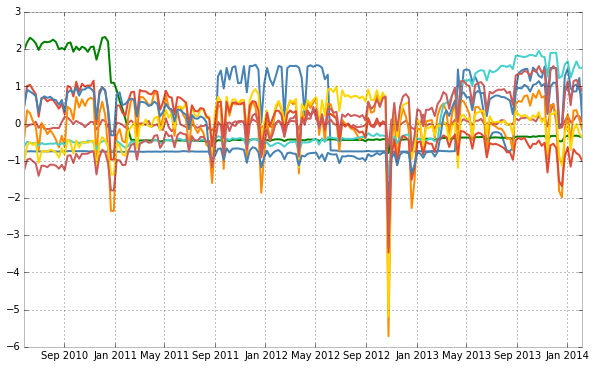

In [26]:
# Plotting the clusters centroids
pl.figure(figsize=(10,6))
for i in range(9):
    pl.plot(weeks, centroids[i])